# 1. Data Preprocessing

In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.nn import GATConv

In [39]:
# Import data

def import_train_data(dir):
    df = None
    min_cols,max_cols = (None,None)
    for file in os.listdir(dir):
        print(f"train: {file}")
        _df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        _df = _df.drop(columns=[0])
        if df is None:
            df = _df
        else:
            df = pd.concat([df,_df])

    min_cols = df.min()
    max_cols = df.max()
    df = (df-df.min())/(df.max()-df.min())
        
    return df, min_cols, max_cols

def import_test_data(dir, min_cols, max_cols):
    dfs = []

    for file in os.listdir(dir):
        print(f"test: {file}")
        _df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        _df = _df.drop(columns=[0])        
        _df = (_df-min_cols)/(max_cols-min_cols)
        dfs.append(_df)
        
    return dfs

train_df, train_min, train_max = import_train_data("/Users/faith/Desktop/Projects/tsad/data/train")
test_dfs = import_test_data("/Users/faith/Desktop/Projects/tsad/data/test", train_min, train_max)

# Convert to Tensors

dropout = 10
train = torch.FloatTensor(train_df[::dropout].values)

train: 07112001.txt
train: 06112001.txt
train: 08112001.txt
train: 05112001.txt
test: 20112001.txt
test: 30102001.txt
test: 17112001.txt
test: 09112001.txt


In [74]:
# Create Dataset Class

class TimewindowDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        
    def __len__(self):
        return self.data.shape[0]//self.window_size
        #return self.data.shape[0] - self.window_size
    
    def __getitem__(self,i):
        return self.data[i*self.window_size:(i+1)*self.window_size]
        #return self.data[i:i+self.window_size]
    
window_size = 80
num_sensors = train.shape[1]
train_dataset = TimewindowDataset(train, window_size)
train_dataloader = DataLoader(train_dataset, shuffle=True)

# Aside: GATConv Example

https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


x = torch.tensor([[100,98],[-1,0],[.001,.003]], dtype=torch.float)
"""
NOTES:
edge_index[0] = source nodes
edge_index[1] = target nodes
edge_index should not be a complete, undirected graph!
"""
edge_index = torch.tensor([[1,2],[0,0]],dtype=torch.long)
data = Data(x=x, edge_index=edge_index)
conv1 = GATConv(data.num_features, data.num_features, heads=1, dropout=0.0,add_self_loops=False,bias=True)
conv1(data.x,data.edge_index,return_attention_weights=True)

# 2. Model

In [85]:
# 1D Conv + 2 GATs + GRU + FFN

class GATModel(torch.nn.Module):
    def __init__(self, window_size, num_sensors, dropout=0., heads=1, kernel_size=7):
        """
        n = nu
        mber timesteps
        k = number sensors
        """
        super().__init__()
        self.window_size = window_size
        self.num_sensors = num_sensors
        self.heads = heads
        self.edge_indexes = self.complete_edge_index(num_sensors)
        self.encoder_1 = nn.ModuleList([GATConv(window_size, window_size, concat=True, heads=heads, dropout=dropout, add_self_loops=False, bias=True) for i in range(num_sensors)])
        #self.encoder_2 = nn.ModuleList([GATConv(-1, window_size//4, concat=True, heads=heads, dropout=dropout, add_self_loops=False, bias=True) for i in range(num_sensors)])
        #self.decoder_1 = nn.ModuleList([GATConv(-1, window_size//2, concat=True, heads=heads, dropout=dropout, add_self_loops=False, bias=True) for i in range(num_sensors)])
        self.decoder_2 = nn.ModuleList([GATConv(-1, window_size, concat=False, heads=heads, dropout=dropout, add_self_loops=False, bias=True) for i in range(num_sensors)])
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self,x):
        x = x.T
        x = self.gat_forward(x,self.encoder_1,last=False)
        x = self.gat_forward(x,self.decoder_2,last=True)
        return x.T
    
    def gat_forward(self,x,layer, last):
        gat_output = None
        for i in range(self.num_sensors):
            edge_index = self.edge_indexes[i]
            node_gat = layer[i]
            node_output, node_attention = node_gat(x, edge_index,return_attention_weights=True)
            node_output = node_output[i]
            """if last:
                node_output = node_output[i]
            else:
                node_output = self.dropout(self.relu(node_output))[i]"""
            gat_output = node_output if gat_output is None else torch.vstack((gat_output,node_output))
        return gat_output
            
            
    def complete_edge_index(self, num_nodes):
        edge_indexes = [None]*num_nodes
        nodes = list(range(num_nodes))
        for node in range(num_nodes):
            target = [node]*(num_nodes-1)
            source = nodes[:node]+nodes[node+1:]
            edge_indexes[node] = [source,target]
        edge_indexes = torch.tensor(edge_indexes)
        
        return edge_indexes

# 3. Training

In [87]:
torch.set_printoptions(threshold=100)

learn_rate=5e-5
EPOCHS = 100
model = GATModel(window_size, num_sensors, heads=5, dropout=0.01)

"""for name, param in model.named_parameters():
    if param.requires_grad:
        print( name, param.data, param.data.shape)"""
        
criterion = nn.MSELoss(reduction="sum") #mean
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
for epoch in range(0,EPOCHS):
    for i,time_window in enumerate(train_dataloader):
        time_window = time_window.squeeze()
        reconstruction = model(time_window)
        model.zero_grad()
        loss = criterion(reconstruction,time_window)
        loss.backward()
        optimizer.step()
        if i%50 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS}, item {i}/{len(train_dataloader)}, loss {loss.item()}")


Epoch 1/100, item 0/432, loss 1047.033203125
Epoch 1/100, item 50/432, loss 518.3070678710938
Epoch 1/100, item 100/432, loss 59.07475280761719
Epoch 1/100, item 150/432, loss 82.24169158935547
Epoch 1/100, item 200/432, loss 26.479328155517578
Epoch 1/100, item 250/432, loss 12.265664100646973
Epoch 1/100, item 300/432, loss 31.324392318725586
Epoch 1/100, item 350/432, loss 10.518404960632324
Epoch 1/100, item 400/432, loss 50.185508728027344
Epoch 2/100, item 0/432, loss 15.118461608886719
Epoch 2/100, item 50/432, loss 34.984954833984375
Epoch 2/100, item 100/432, loss 30.192672729492188
Epoch 2/100, item 150/432, loss 24.101186752319336
Epoch 2/100, item 200/432, loss 8.8455171585083
Epoch 2/100, item 250/432, loss 33.832740783691406
Epoch 2/100, item 300/432, loss 29.738943099975586
Epoch 2/100, item 350/432, loss 17.570449829101562
Epoch 2/100, item 400/432, loss 43.85506820678711
Epoch 3/100, item 0/432, loss 44.03255081176758
Epoch 3/100, item 50/432, loss 19.547000885009766
E

Epoch 19/100, item 0/432, loss 17.95392608642578
Epoch 19/100, item 50/432, loss 10.725866317749023
Epoch 19/100, item 100/432, loss 16.26612663269043
Epoch 19/100, item 150/432, loss 20.325576782226562
Epoch 19/100, item 200/432, loss 20.482067108154297
Epoch 19/100, item 250/432, loss 13.6331787109375
Epoch 19/100, item 300/432, loss 25.890274047851562
Epoch 19/100, item 350/432, loss 14.779988288879395
Epoch 19/100, item 400/432, loss 18.664058685302734
Epoch 20/100, item 0/432, loss 15.263538360595703
Epoch 20/100, item 50/432, loss 10.422943115234375
Epoch 20/100, item 100/432, loss 18.06517791748047
Epoch 20/100, item 150/432, loss 7.527785301208496
Epoch 20/100, item 200/432, loss 12.197816848754883
Epoch 20/100, item 250/432, loss 7.255306243896484
Epoch 20/100, item 300/432, loss 10.569781303405762
Epoch 20/100, item 350/432, loss 14.709273338317871
Epoch 20/100, item 400/432, loss 9.69821834564209
Epoch 21/100, item 0/432, loss 8.084609985351562
Epoch 21/100, item 50/432, los

Epoch 36/100, item 400/432, loss 8.467131614685059
Epoch 37/100, item 0/432, loss 9.07275390625
Epoch 37/100, item 50/432, loss 11.67017936706543
Epoch 37/100, item 100/432, loss 11.126812934875488
Epoch 37/100, item 150/432, loss 15.210585594177246
Epoch 37/100, item 200/432, loss 7.527099609375
Epoch 37/100, item 250/432, loss 6.471705436706543
Epoch 37/100, item 300/432, loss 8.7892484664917
Epoch 37/100, item 350/432, loss 9.485154151916504
Epoch 37/100, item 400/432, loss 9.295515060424805
Epoch 38/100, item 0/432, loss 19.39381980895996
Epoch 38/100, item 50/432, loss 15.46535587310791
Epoch 38/100, item 100/432, loss 9.266669273376465
Epoch 38/100, item 150/432, loss 14.20956802368164
Epoch 38/100, item 200/432, loss 18.483205795288086
Epoch 38/100, item 250/432, loss 11.052599906921387
Epoch 38/100, item 300/432, loss 15.78996467590332
Epoch 38/100, item 350/432, loss 20.849258422851562
Epoch 38/100, item 400/432, loss 16.02709197998047
Epoch 39/100, item 0/432, loss 6.75438213

Epoch 54/100, item 400/432, loss 9.765153884887695
Epoch 55/100, item 0/432, loss 31.960128784179688
Epoch 55/100, item 50/432, loss 21.315736770629883
Epoch 55/100, item 100/432, loss 14.478080749511719
Epoch 55/100, item 150/432, loss 7.581279277801514
Epoch 55/100, item 200/432, loss 7.93166971206665
Epoch 55/100, item 250/432, loss 13.410386085510254
Epoch 55/100, item 300/432, loss 10.143694877624512
Epoch 55/100, item 350/432, loss 10.454679489135742
Epoch 55/100, item 400/432, loss 6.627225399017334
Epoch 56/100, item 0/432, loss 7.016851425170898
Epoch 56/100, item 50/432, loss 7.140933513641357
Epoch 56/100, item 100/432, loss 8.785008430480957
Epoch 56/100, item 150/432, loss 6.254097938537598
Epoch 56/100, item 200/432, loss 12.364745140075684
Epoch 56/100, item 250/432, loss 7.694141387939453
Epoch 56/100, item 300/432, loss 5.397023677825928
Epoch 56/100, item 350/432, loss 6.8195648193359375
Epoch 56/100, item 400/432, loss 39.37892150878906
Epoch 57/100, item 0/432, loss

Epoch 72/100, item 350/432, loss 13.915201187133789
Epoch 72/100, item 400/432, loss 6.6386518478393555
Epoch 73/100, item 0/432, loss 10.134225845336914
Epoch 73/100, item 50/432, loss 6.654778957366943
Epoch 73/100, item 100/432, loss 9.287334442138672
Epoch 73/100, item 150/432, loss 7.041256427764893
Epoch 73/100, item 200/432, loss 5.4953532218933105
Epoch 73/100, item 250/432, loss 10.344090461730957
Epoch 73/100, item 300/432, loss 6.943452835083008
Epoch 73/100, item 350/432, loss 9.824687957763672
Epoch 73/100, item 400/432, loss 8.215119361877441
Epoch 74/100, item 0/432, loss 7.141236782073975
Epoch 74/100, item 50/432, loss 9.326412200927734
Epoch 74/100, item 100/432, loss 9.085259437561035
Epoch 74/100, item 150/432, loss 8.018941879272461
Epoch 74/100, item 200/432, loss 5.975383758544922
Epoch 74/100, item 250/432, loss 7.173526763916016
Epoch 74/100, item 300/432, loss 7.715157508850098
Epoch 74/100, item 350/432, loss 8.82607650756836
Epoch 74/100, item 400/432, loss 

Epoch 90/100, item 350/432, loss 10.645305633544922
Epoch 90/100, item 400/432, loss 10.295381546020508
Epoch 91/100, item 0/432, loss 8.074048042297363
Epoch 91/100, item 50/432, loss 6.730339050292969
Epoch 91/100, item 100/432, loss 11.515058517456055
Epoch 91/100, item 150/432, loss 7.714252948760986
Epoch 91/100, item 200/432, loss 10.901659965515137
Epoch 91/100, item 250/432, loss 5.497445106506348
Epoch 91/100, item 300/432, loss 6.696747303009033
Epoch 91/100, item 350/432, loss 11.311798095703125
Epoch 91/100, item 400/432, loss 7.587928771972656
Epoch 92/100, item 0/432, loss 12.723516464233398
Epoch 92/100, item 50/432, loss 8.237700462341309
Epoch 92/100, item 100/432, loss 9.782928466796875
Epoch 92/100, item 150/432, loss 5.824731349945068
Epoch 92/100, item 200/432, loss 9.821588516235352
Epoch 92/100, item 250/432, loss 28.701309204101562
Epoch 92/100, item 300/432, loss 7.56171989440918
Epoch 92/100, item 350/432, loss 7.987390518188477
Epoch 92/100, item 400/432, los

In [94]:
PATH = "ae_gat_test.pt"
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

# 4. Eval

In [89]:
#test = data[int(timesteps*.8):]
#test = torch.FloatTensor(test)
#test_dataset = TimewindowDataset(test, window_size)
#test_dataloader = DataLoader(test_dataset)

In [95]:
anom_start = 58800
anom_end = 59800
t0 = anom_start-2000
t1 = anom_end+2000
anom_df = 1

test = torch.FloatTensor(test_dfs[anom_df][t0:t1][::dropout].values)
"""anom_df = 1
test = torch.FloatTensor(test_dfs[anom_df][::dropout].values)"""
num_timesteps = test.shape[0]
test_dataset = TimewindowDataset(test, window_size)
test_dataloader = DataLoader(test_dataset)
#time = np.arange(t0,t1,dropout)#[:-window_size]

In [96]:
# Eval model without GRU
model.eval()
preds = None
windows = None

for i,window in enumerate(test_dataloader):
    #if i%100==0:
    print(f"item: {i}/{len(test_dataloader)}")
    window = window.squeeze()
    x = model(window)
    '''if i%100 == 0:
        for attn_head in range(alpha_f[1].shape[1]):
            alpha_f_matrix = np.zeros((num_sensors,num_sensors))
            edges = alpha_f[0]
            weights = alpha_f[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_f_matrix[i][j] = weights[idx]
            print("Alpha Spatial")
            print(alpha_f_matrix)
        for attn_head in range(alpha_t[1].shape[1]):
            max_timestep = alpha_t[0][0].max()+1
            alpha_t_matrix = np.zeros((max_timestep,max_timestep))
            edges = alpha_t[0]
            weights = alpha_t[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_t_matrix[i][j] = weights[idx]
            print("Alpha Temporal")
            print(alpha_t_matrix)'''
            
    # Save prediction
    if preds is None:
        preds = x.detach().numpy()
    else:
        preds = np.vstack((preds,x.detach().numpy()))
    # Save infer
    if windows is None:
        windows = window.detach().numpy()
    else:
        windows = np.vstack((windows,window.detach().numpy()))
        

item: 0/6
item: 1/6
item: 2/6
item: 3/6
item: 4/6
item: 5/6


In [97]:
# Save items
np.save("gat_artifacts/ae_gat_windows.npy", windows)
np.save("gat_artifacts/ae_gat_preds.npy", preds)


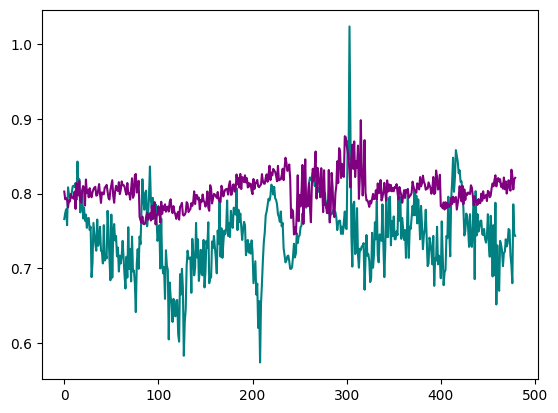

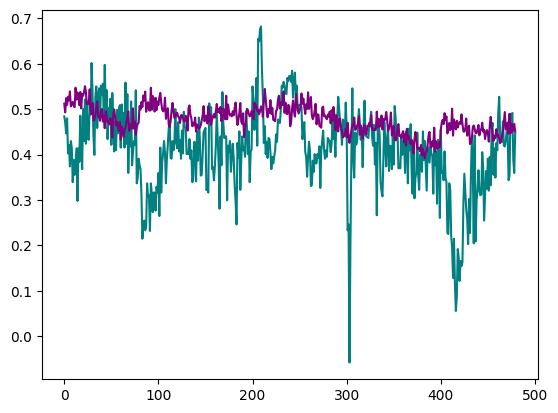

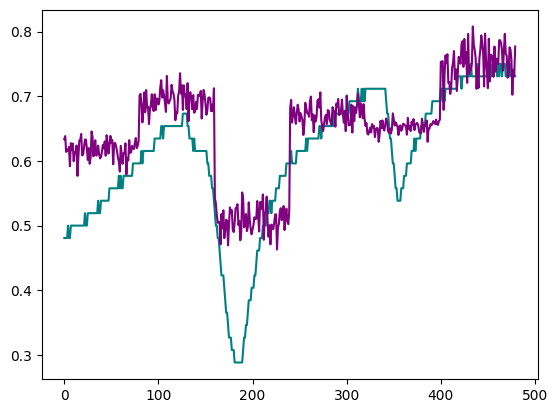

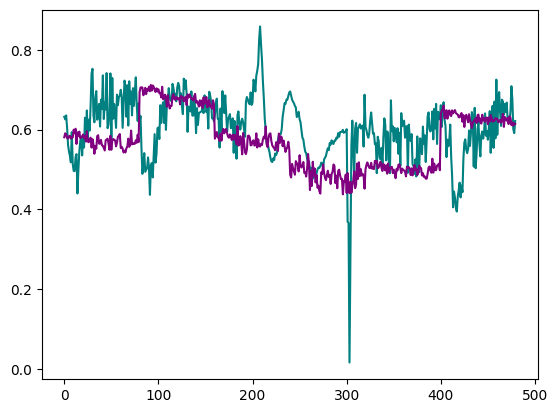

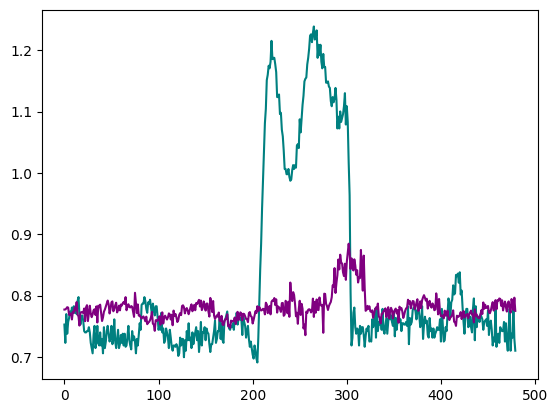

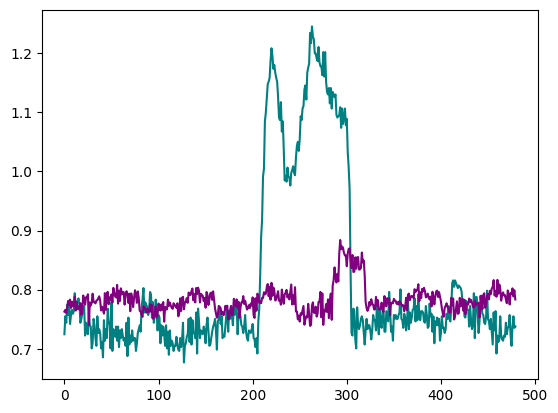

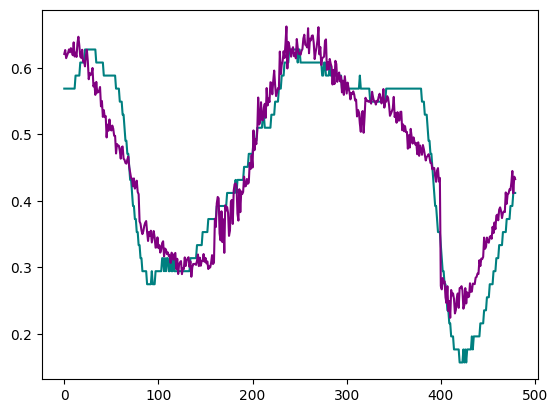

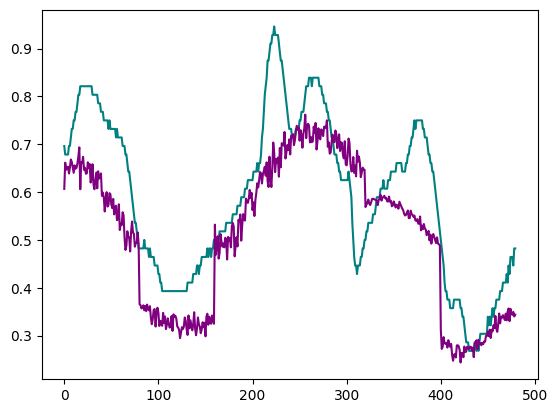

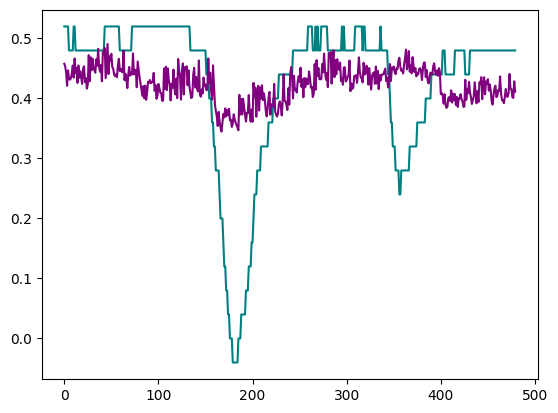

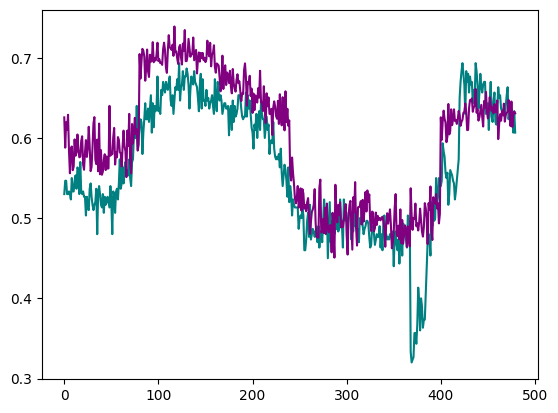

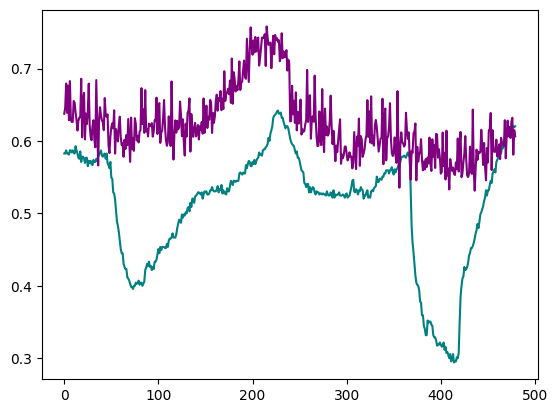

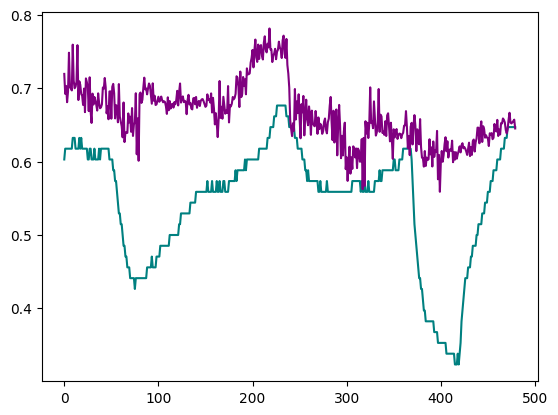

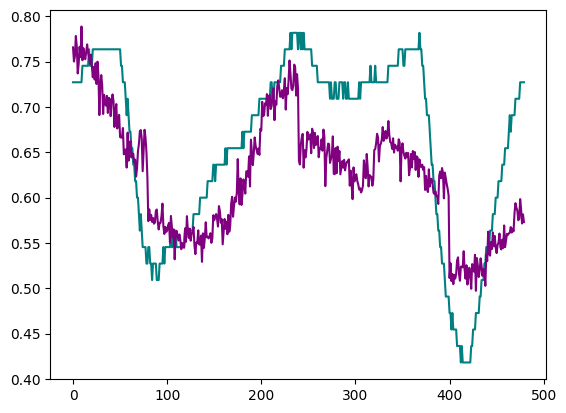

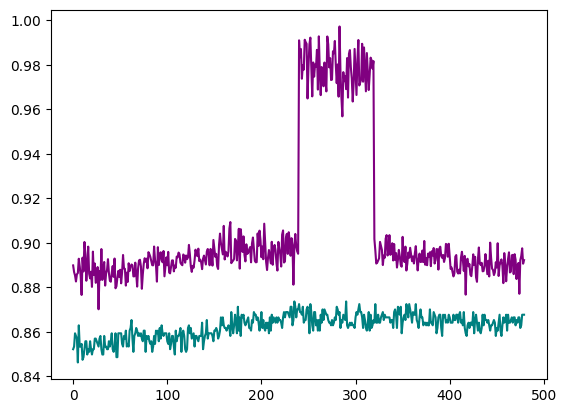

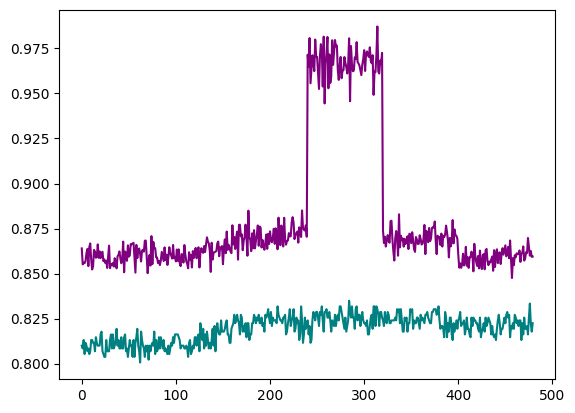

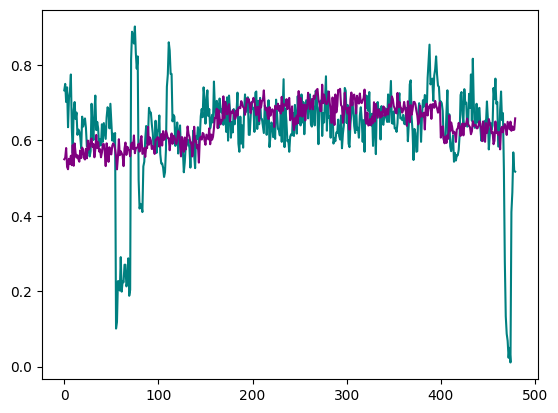

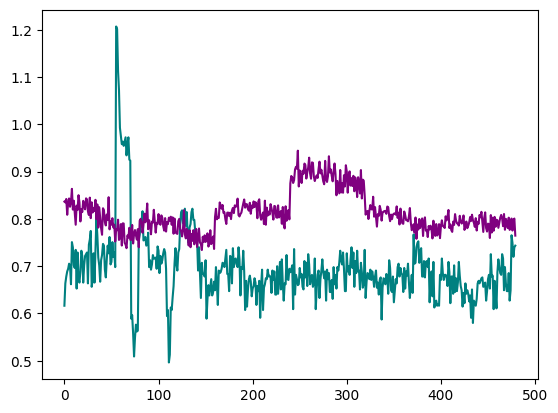

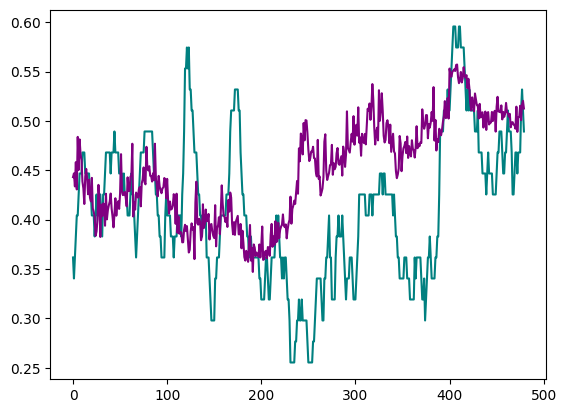

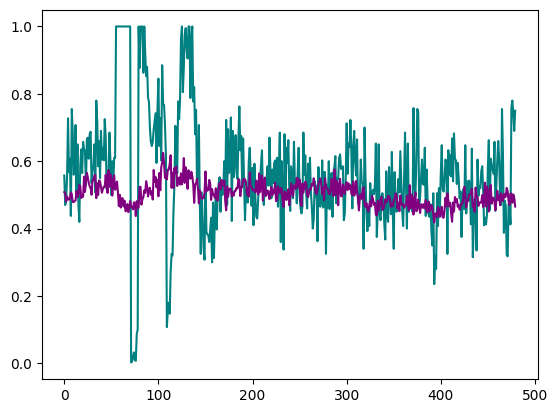

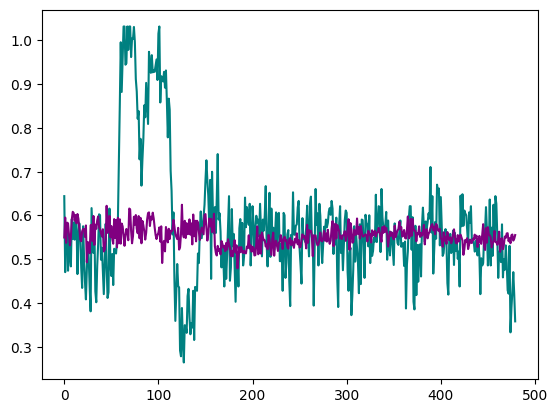

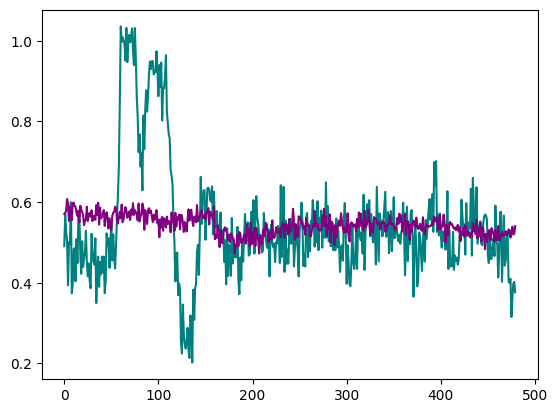

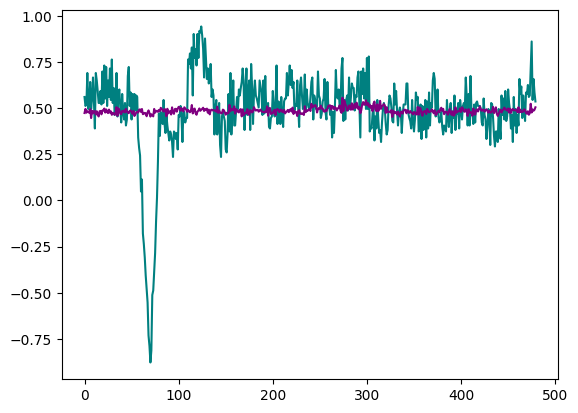

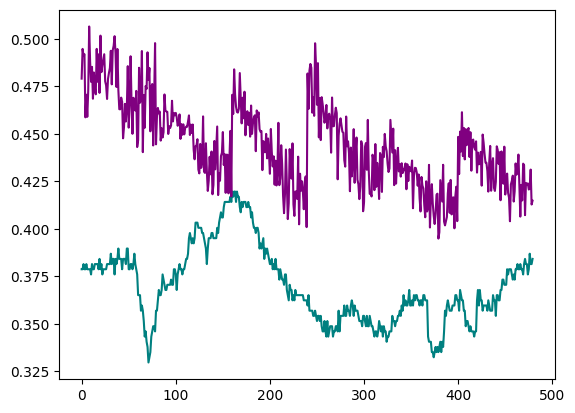

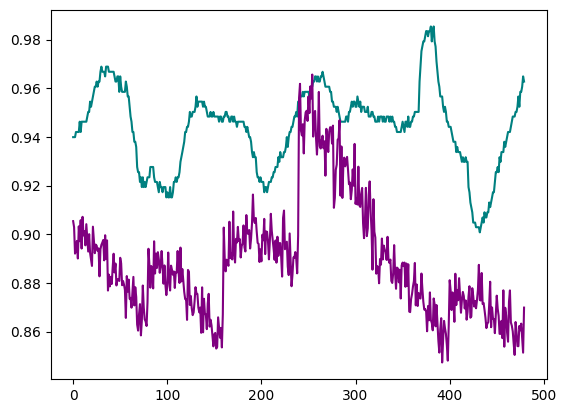

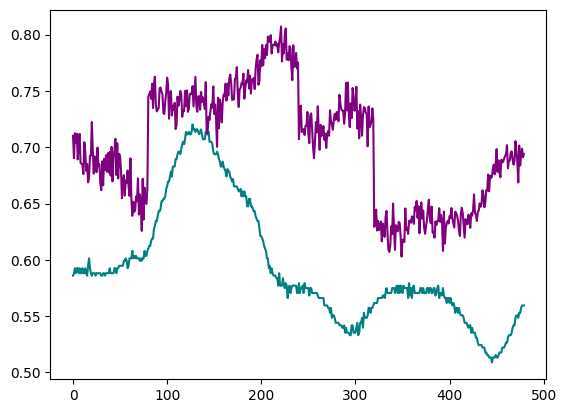

In [98]:
import matplotlib.pyplot as plt

for i in range(windows.shape[1]):
    plt.plot(windows[:,i], label="target", c="teal")
    plt.plot(preds[:,i], label="pred", c="purple")
    plt.show()

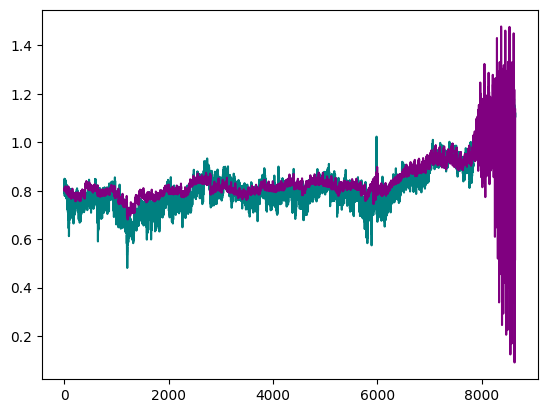

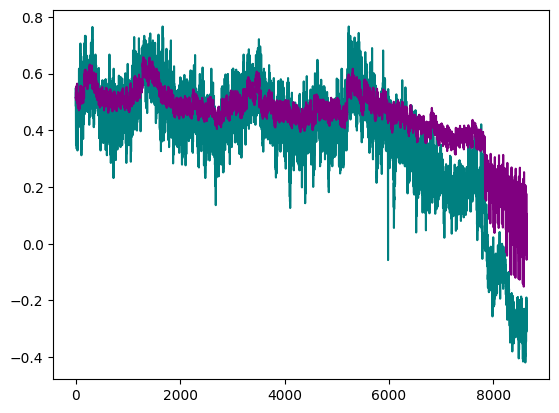

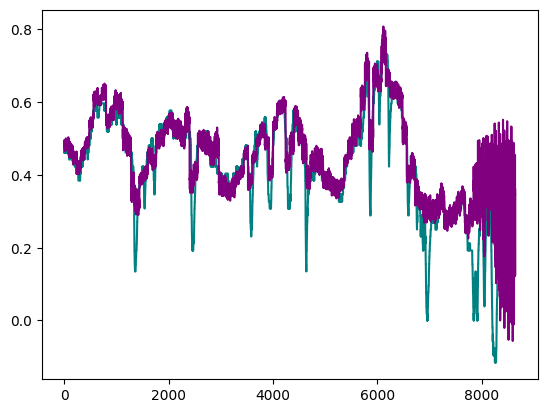

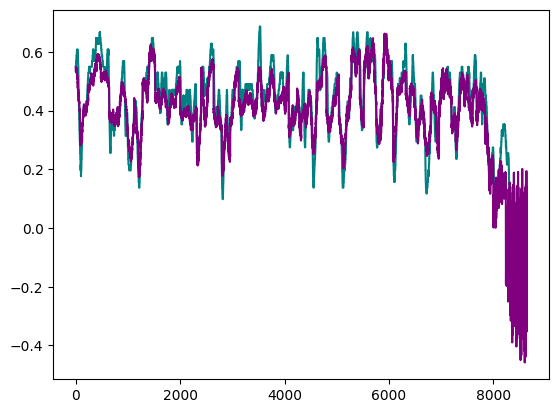

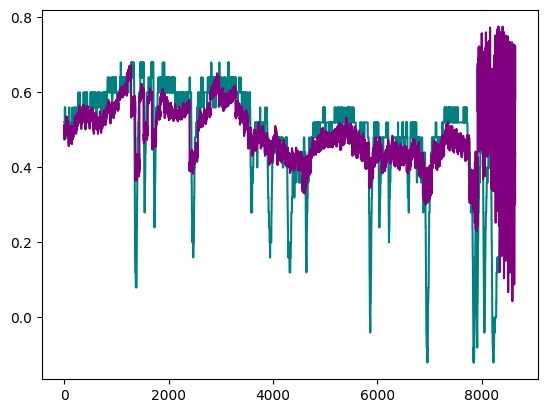

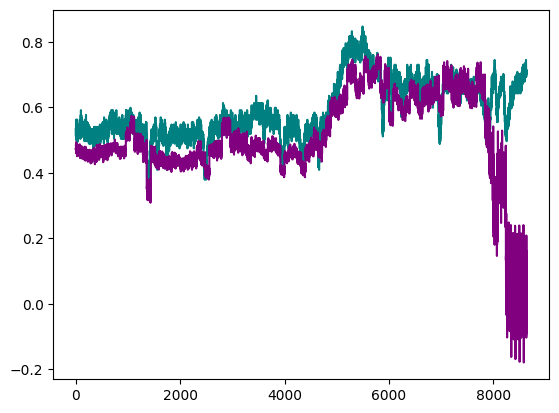

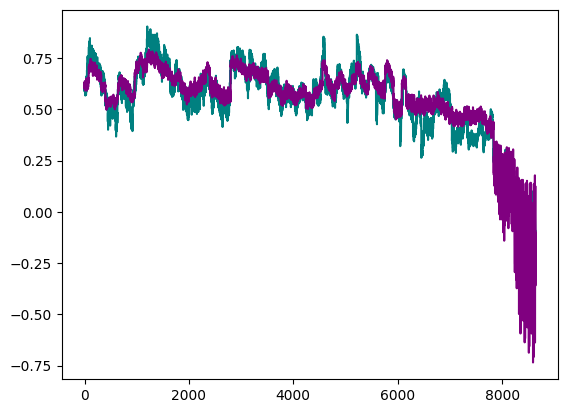

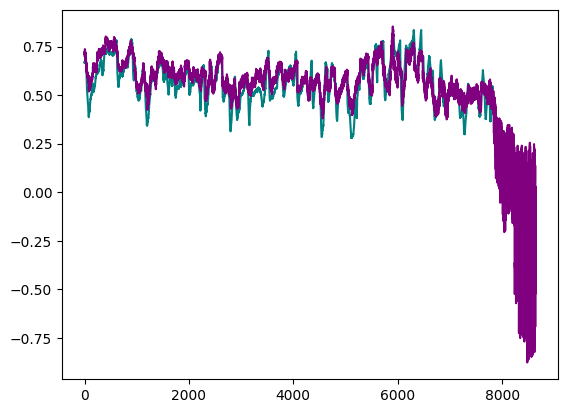

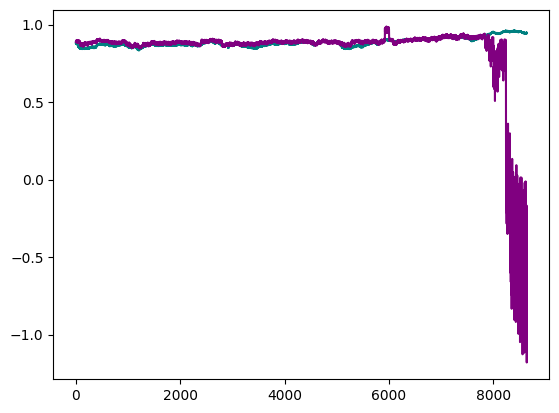

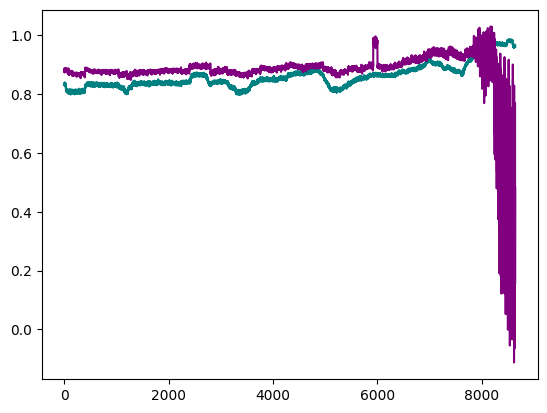

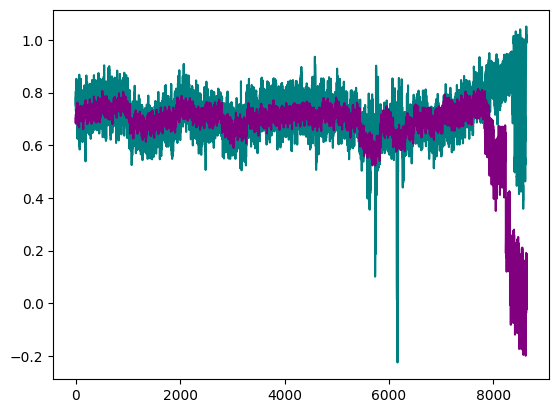

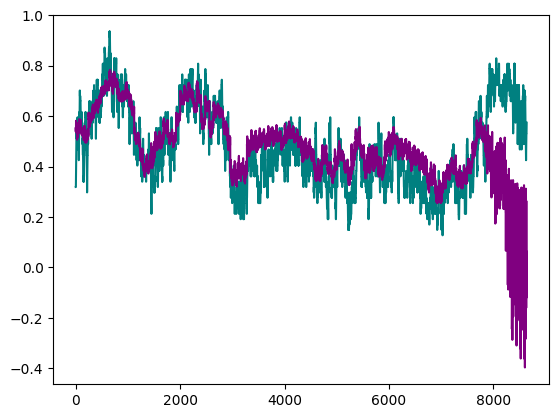

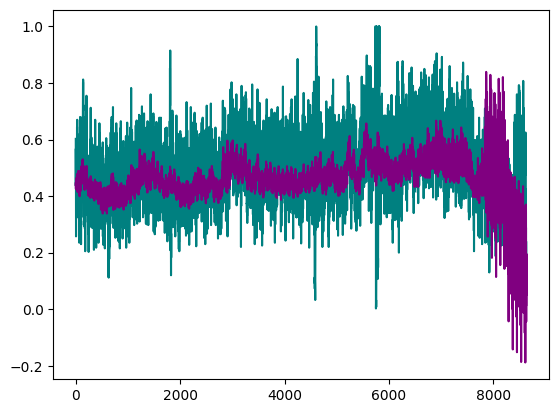

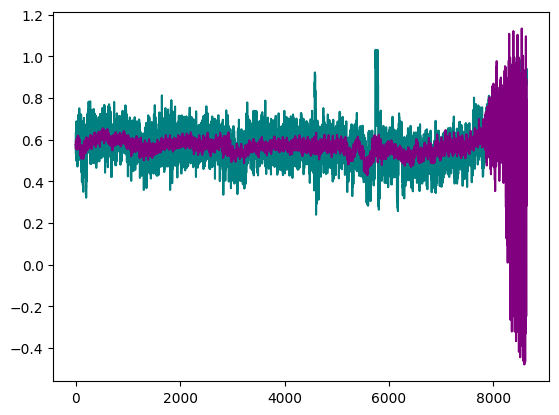

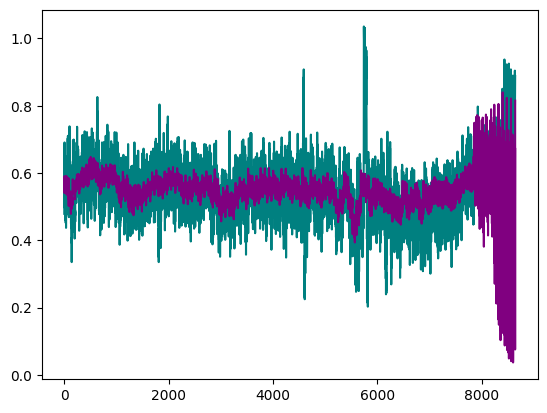

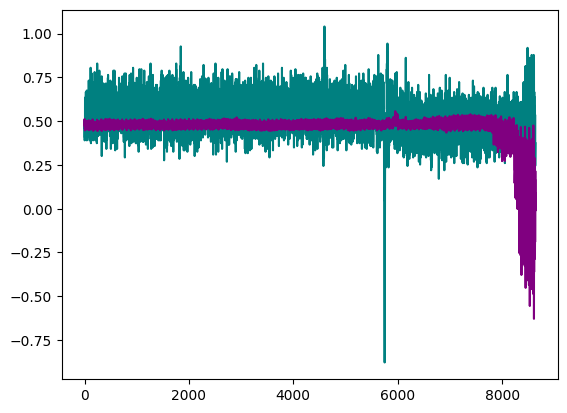

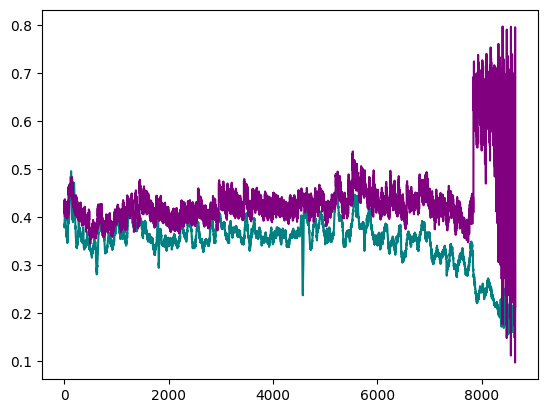

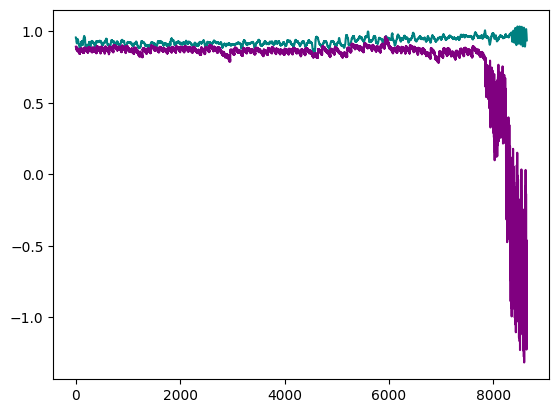

In [93]:
import matplotlib.pyplot as plt

for i in range(windows.shape[1]):
    plt.plot(windows[:,i], label="target", c="teal")
    plt.plot(preds[:,i], label="pred", c="purple")
    plt.show()

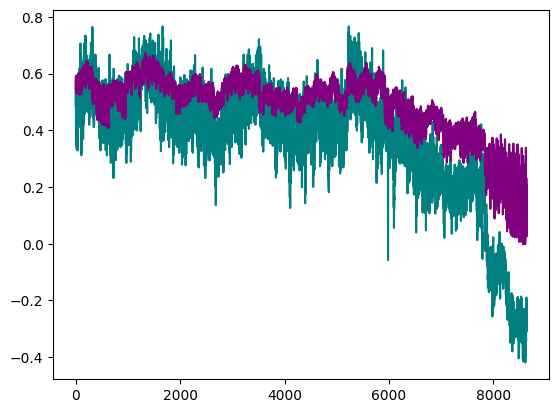

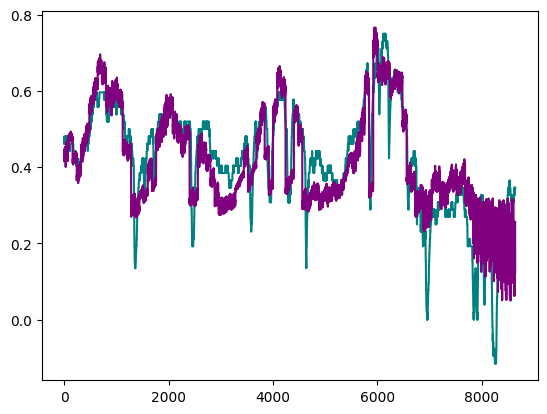

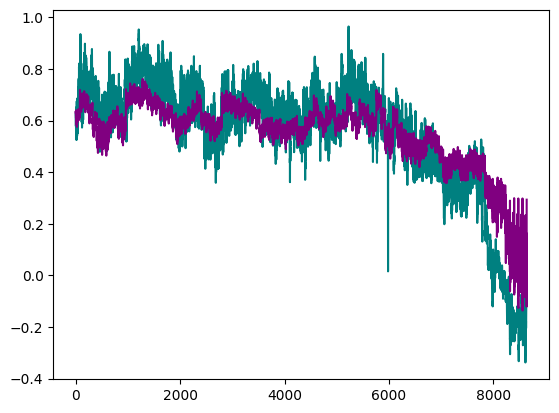

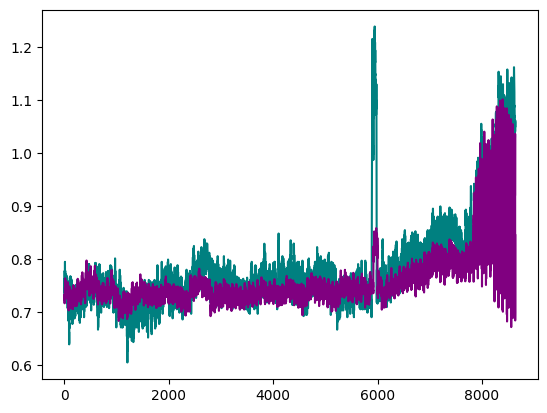

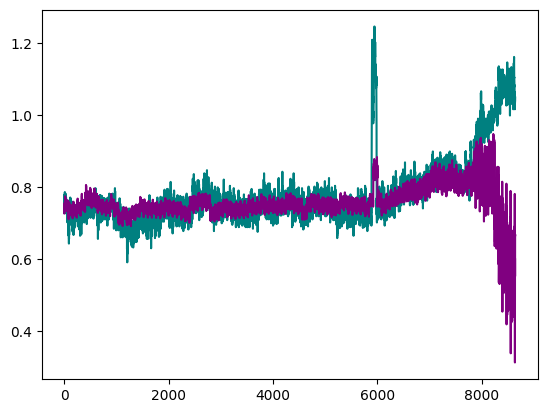

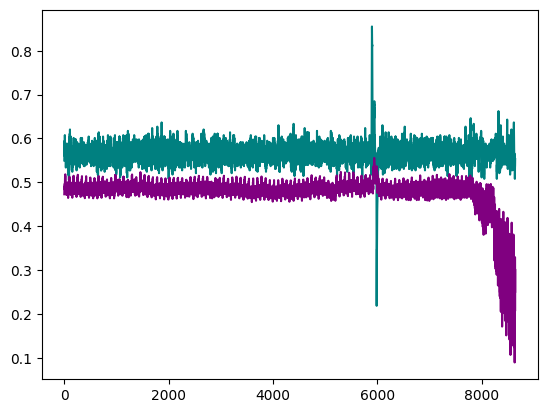

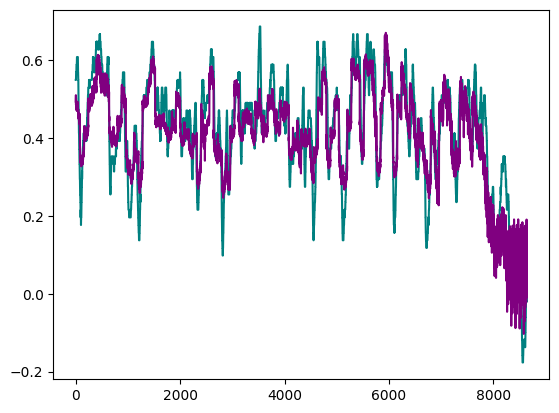

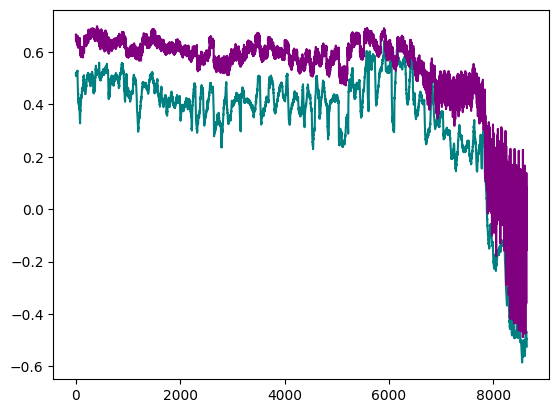

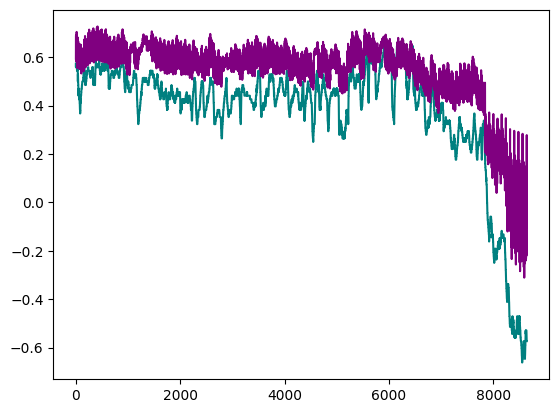

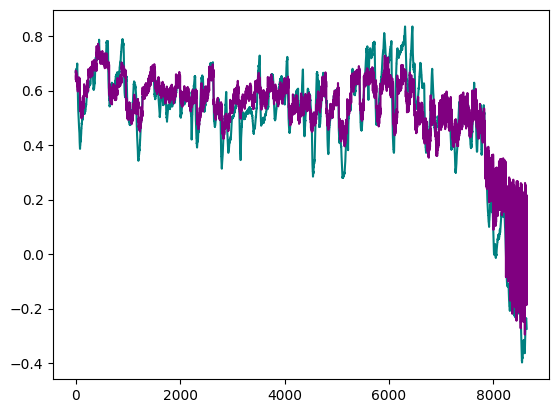

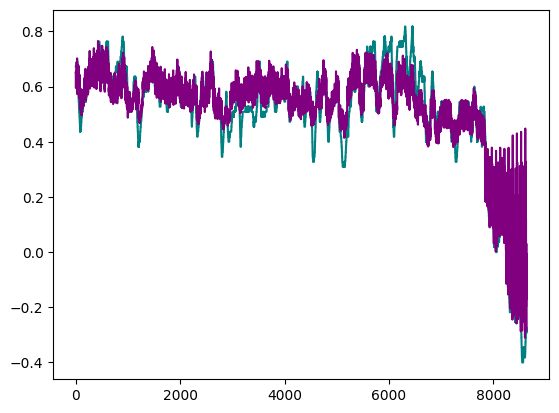

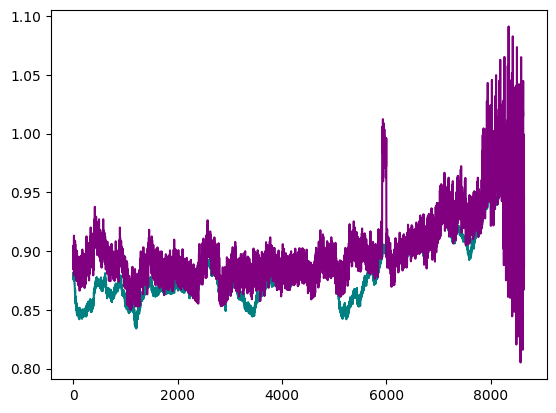

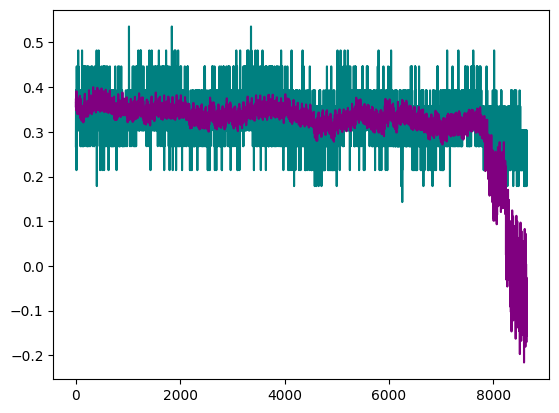

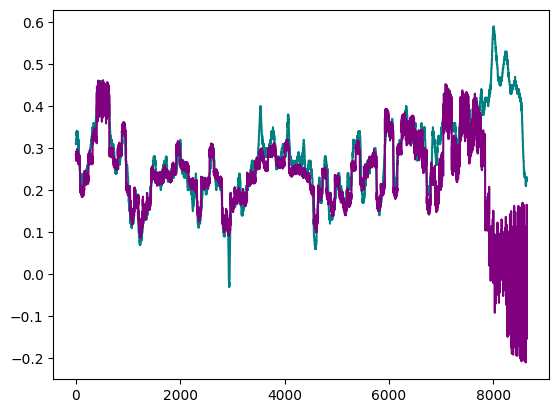

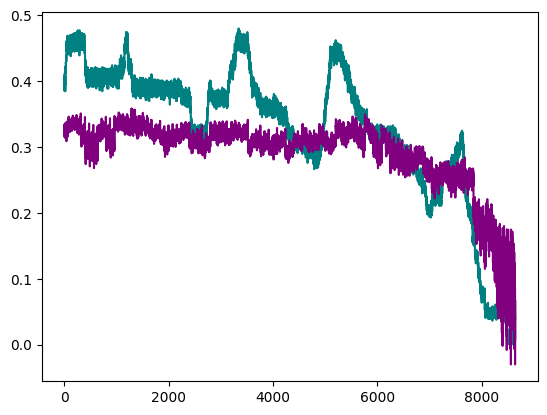

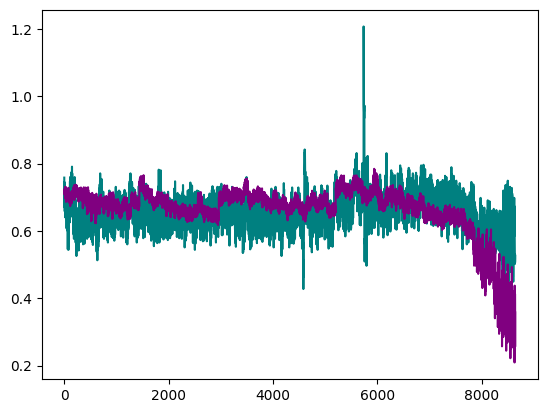

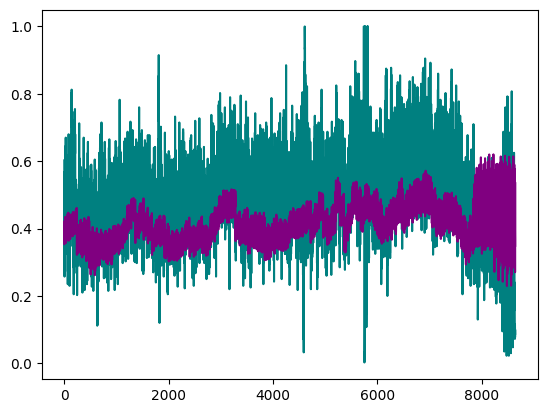

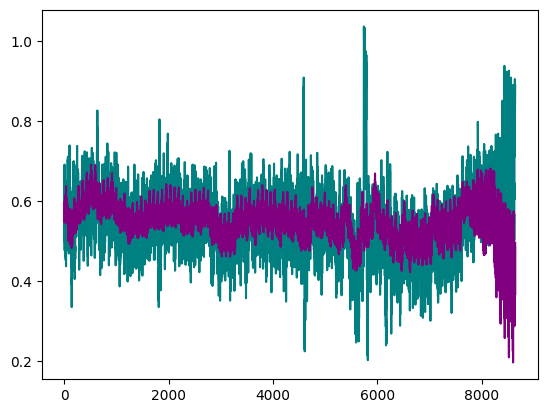

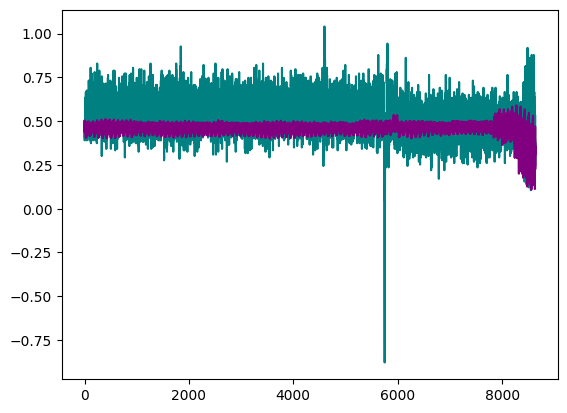

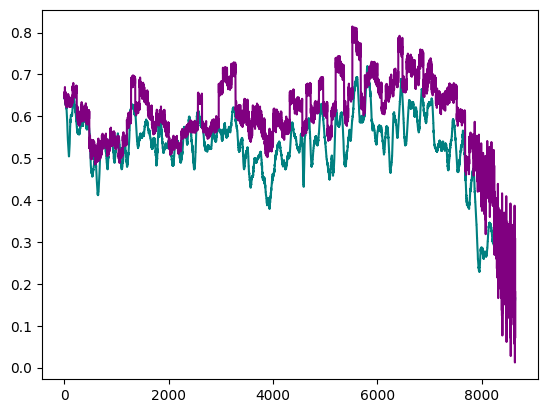

In [55]:
import matplotlib.pyplot as plt

for i in range(windows.shape[1]):
    plt.plot(windows[:,i], label="target", c="teal")
    plt.plot(preds[:,i], label="pred", c="purple")
    plt.show()

# 5. Eval w/ Global Anomaly

In [130]:
# Global Outlier: Benchmark
test = torch.FloatTensor(test_dfs[anom_df][t0:t1][::dropout].values)
test_anom = np.copy(test)

num_timesteps,_ = test.shape

test_anom[int(num_timesteps*.7):int(num_timesteps*.7+30),1] = test[int(num_timesteps*.7):int(num_timesteps*.7+30),1]*8
test_anom = torch.FloatTensor(test_anom)



In [131]:
# Global Outlier (sinusoidal data)
#test = data[int(timesteps*.8):]
#test_anom = np.copy(test)
#test_anom[int(num_timesteps*.5):int(num_timesteps*.5+30),1] = test[int(num_timesteps*.5):int(num_timesteps*.5+30),1]*8
#test_anom = torch.FloatTensor(test_anom)

In [132]:
test_dataset = TimewindowDataset(test_anom, window_size)
test_dataloader = DataLoader(test_dataset)

In [133]:
#test = torch.FloatTensor(test_dfs[3][::dropout].values)
#test_dataset = TimewindowDataset(test, window_size)
#test_dataloader = DataLoader(test_dataset)

In [134]:
# Eval model without GRU
model.eval()
preds = None
targets_anom = None
attn_f = None
attn_t = None
attn_f_edge_idx = None
attn_t_edge_idx = None

for i,item in enumerate(test_dataloader):
    #if i%100==0:
    print(f"item: {i}/{len(test_dataloader)}")
    window, target = item
    window = window.squeeze()
    target = target.T.squeeze()
    x,alpha_f,alpha_t = model(window)
    '''if i%100 == 0:
        for attn_head in range(alpha_f[1].shape[1]):
            alpha_f_matrix = np.zeros((num_sensors,num_sensors))
            edges = alpha_f[0]
            weights = alpha_f[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_f_matrix[i][j] = weights[idx]
            print("Alpha Spatial")
            print(alpha_f_matrix)
        for attn_head in range(alpha_t[1].shape[1]):
            max_timestep = alpha_t[0][0].max()+1
            alpha_t_matrix = np.zeros((max_timestep,max_timestep))
            edges = alpha_t[0]
            weights = alpha_t[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_t_matrix[i][j] = weights[idx]
            print("Alpha Temporal")
            print(alpha_t_matrix)'''
            
    '''if i >= int(num_timesteps*.5) and i <= num_timesteps*.5+30:
        print("##### ANOMALY #####")

        for attn_head in range(alpha_f[1].shape[1]):
            alpha_f_matrix = np.zeros((num_sensors,num_sensors))
            edges = alpha_f[0]
            weights = alpha_f[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_f_matrix[i][j] = weights[idx]
            print("Alpha ANOMALY Spatial")
            print(alpha_f_matrix)
        for attn_head in range(alpha_t[1].shape[1]):
            max_timestep = alpha_t[0][0].max()+1
            alpha_t_matrix = np.zeros((max_timestep,max_timestep))
            edges = alpha_t[0]
            weights = alpha_t[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_t_matrix[i][j] = weights[idx]
            print("Alpha ANOMALY Temporal")
            print(alpha_t_matrix)'''
            
    if preds is None:
        preds = x.detach().numpy().reshape(-1)
    else:
        preds = np.vstack((preds,x.detach().numpy().reshape(-1)))
    if targets_anom is None:
        targets_anom = target.detach().numpy().reshape(-1)
    else:
        targets_anom = np.vstack((targets_anom,target.detach().numpy().reshape(-1)))
    # Save spatial attention
    if attn_f is None:
        attn_f = np.expand_dims(alpha_f[1].detach().numpy(),axis=0)
    else:
        attn_f = np.vstack((attn_f,np.expand_dims(alpha_f[1].detach().numpy(),axis=0)))   
    # Save temporal attention
    if attn_t is None:
        attn_t = np.expand_dims(alpha_t[1].detach().numpy(),axis=0)
    else:
        attn_t = np.vstack((attn_t,np.expand_dims(alpha_t[1].detach().numpy(),axis=0)))        
    # Save spatial attention edge index (once)
    if attn_f_edge_idx is None:
        attn_f_edge_idx = alpha_f[0].detach().numpy()
    # Save temporal attention edge index (once)        
    if attn_t_edge_idx is None:
        attn_t_edge_idx = alpha_t[0].detach().numpy()      

item: 0/25


ValueError: not enough values to unpack (expected 2, got 1)

In [51]:
# Save items
np.save("gat_artifacts/targets_global_anom.npy", targets_anom)
np.save("gat_artifacts/preds_global_anom.npy", preds)
np.save("gat_artifacts/attn_f_global_anom.npy", attn_f)
np.save("gat_artifacts/attn_t_global_anom.npy", attn_t)
np.save("gat_artifacts/attn_f_edge_idx_global_anom.npy", attn_f_edge_idx)
np.save("gat_artifacts/attn_t_edge_idx_global_anom.npy", attn_t_edge_idx)


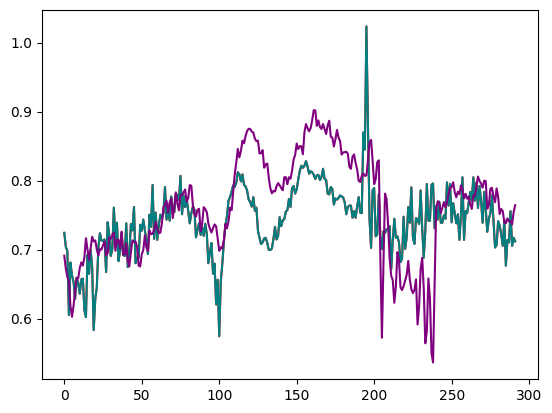

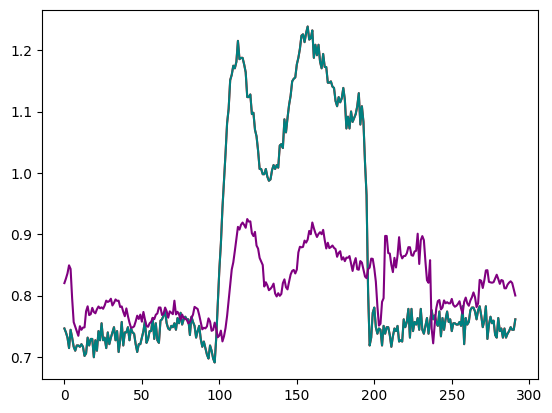

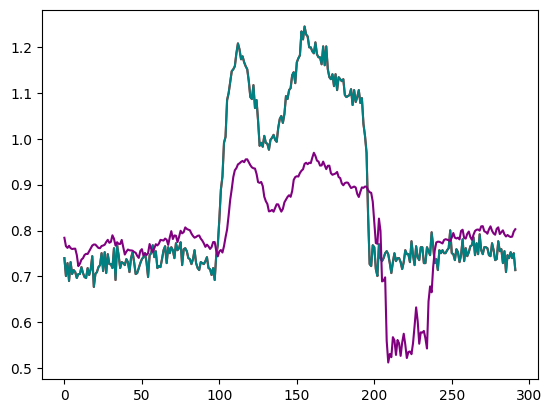

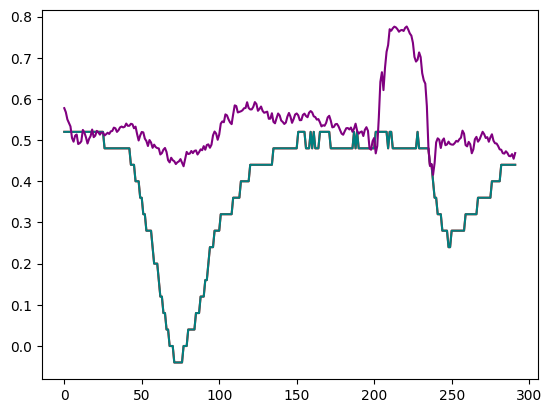

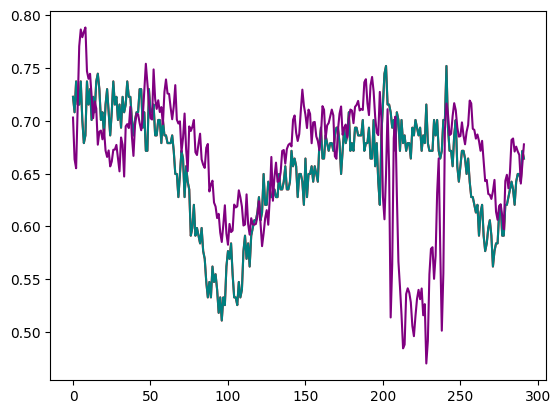

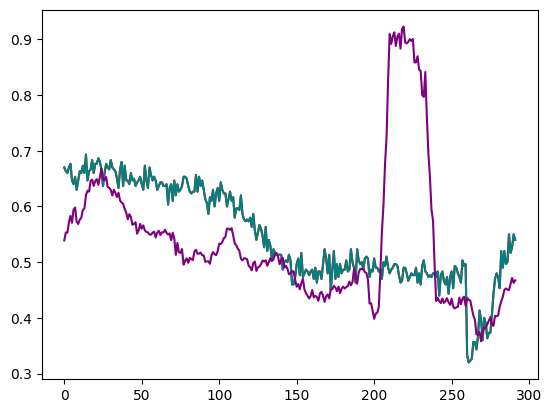

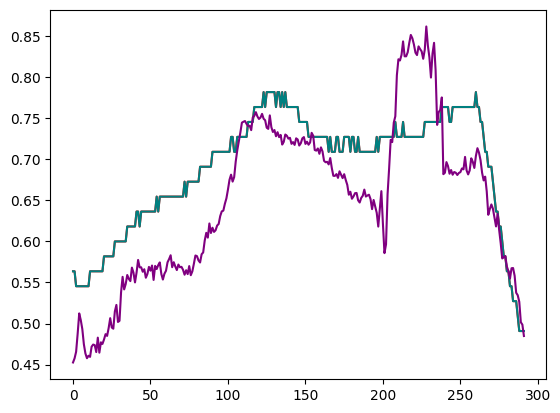

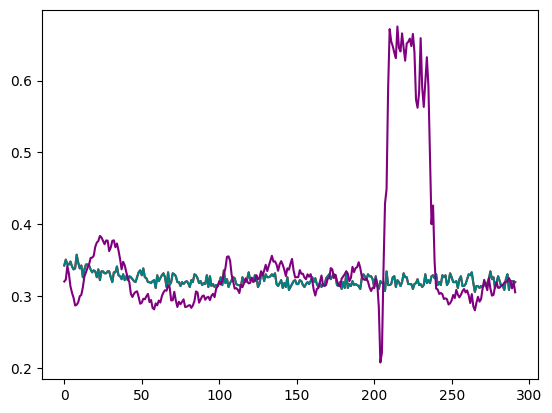

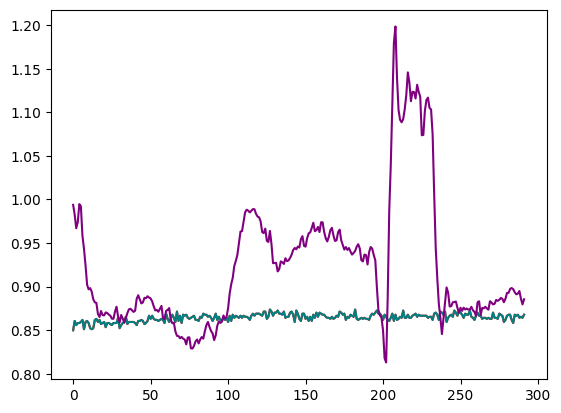

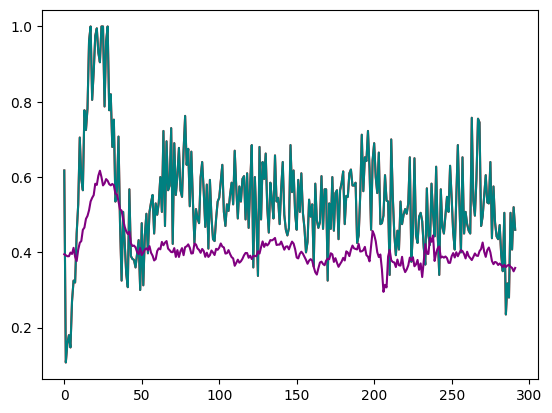

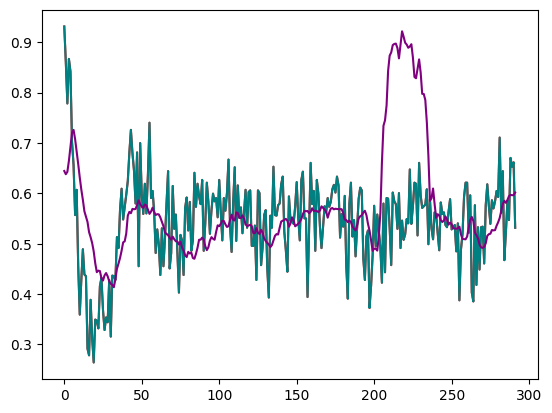

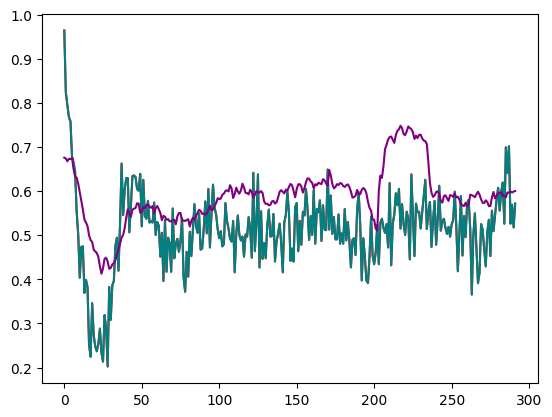

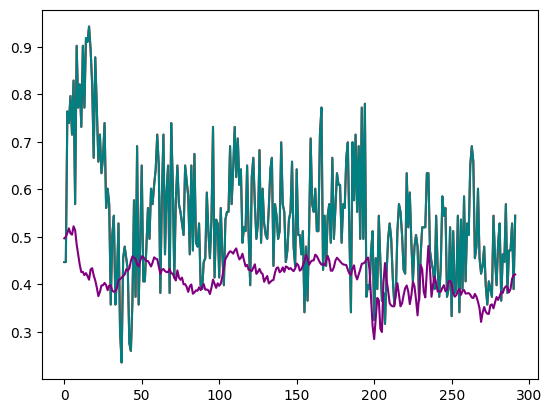

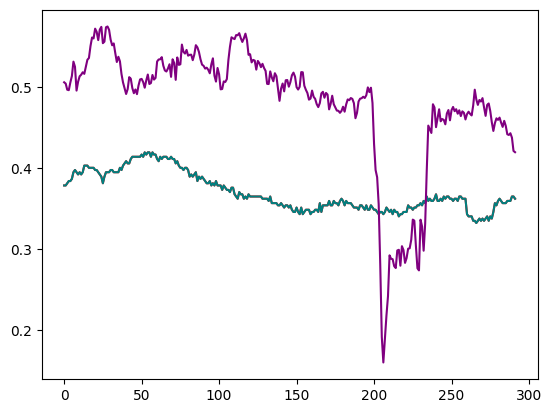

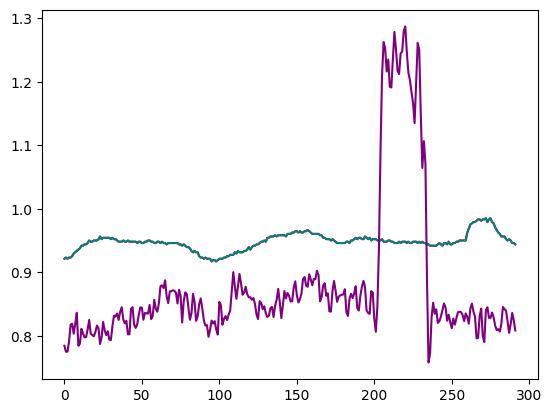

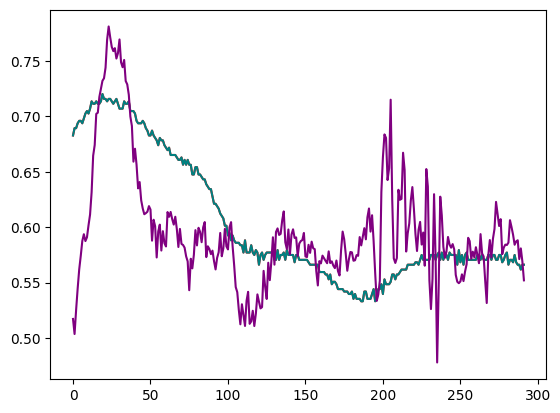

In [52]:
# With 1D Convolution and both GATs
import matplotlib.pyplot as plt

for i in range(window.shape[1]):
    plt.plot(targets_anom[:,i], label="target_anom", c="red")
    plt.plot(targets[:,i], label="target",c="teal")
    plt.plot(preds[:,i], label="pred", c="purple")
    plt.show()

# 6. Eval w/ Trend Anomaly

In [53]:
# Trend Outlier: Benchmark

test = torch.FloatTensor(test_dfs[anom_df][t0:t1][::dropout].values)
test_anom = np.copy(test)

num_timesteps,_ = test.shape

test_anom[int(num_timesteps*.5):,10] = test[int(num_timesteps*.5):,10]+0.1+np.linspace(0,test[int(num_timesteps*.5):,10].max(),len(test[int(num_timesteps*.5):,10]))
test_anom = torch.FloatTensor(test_anom)



In [54]:
# Trend Outlier: Sinusoidal Data
#test = data[int(timesteps*.8):]
#test_anom = np.copy(test)
#test_anom[int(num_timesteps*.5):,0] = test[int(num_timesteps*.5):,0]+0.1+np.linspace(0,test[int(num_timesteps*.5):,0].max(),len(test[int(num_timesteps*.5):,0]))
#test_anom = torch.FloatTensor(test_anom)

In [55]:
test_anom_dataset = TimewindowDataset(test_anom, window_size)
test_anom_dataloader = DataLoader(test_anom_dataset)

In [56]:
#test = torch.FloatTensor(test_dfs[3][::dropout].values)
#test_dataset = TimewindowDataset(test, window_size)
#test_dataloader = DataLoader(test_dataset)

In [57]:
# Eval model without GRU
model.eval()
preds = None
targets_anom = None
attn_f = None
attn_t = None
attn_f_edge_idx = None
attn_t_edge_idx = None

for i,item in enumerate(test_anom_dataloader):
    if i%100==0:
        print(f"item: {i}/{len(test_dataloader)}")
    window, target = item
    window = window.squeeze()
    target = target.T.squeeze()
    
    x,alpha_f,alpha_t = model(window)
    '''if i%100 == 0:
        if i >= int(num_timesteps*.5):
            print("*** ANOMALY ***")
        for attn_head in range(alpha_f[1].shape[1]):
            alpha_f_matrix = np.zeros((num_sensors,num_sensors))
            edges = alpha_f[0]
            weights = alpha_f[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_f_matrix[i][j] = weights[idx]
            print("Alpha Spatial")
            print(alpha_f_matrix)
        for attn_head in range(alpha_t[1].shape[1]):
            max_timestep = alpha_t[0][0].max()+1
            alpha_t_matrix = np.zeros((max_timestep,max_timestep))
            edges = alpha_t[0]
            weights = alpha_t[1][:,attn_head]
            #print(edges)
            #print(weights)
            for idx in range(len(edges[0])):
                i,j = edges[0][idx],edges[1][idx]
                alpha_t_matrix[i][j] = weights[idx]
            print("Alpha Temporal")
            print(alpha_t_matrix)'''
            
    if preds is None:
        preds = x.detach().numpy().reshape(-1)
    else:
        preds = np.vstack((preds,x.detach().numpy().reshape(-1)))
    if targets_anom is None:
        targets_anom = target.detach().numpy().reshape(-1)
    else:
        targets_anom = np.vstack((targets_anom,target.detach().numpy().reshape(-1)))
    # Save spatial attention
    if attn_f is None:
        attn_f = np.expand_dims(alpha_f[1].detach().numpy(),axis=0)
    else:
        attn_f = np.vstack((attn_f,np.expand_dims(alpha_f[1].detach().numpy(),axis=0)))   
    # Save temporal attention
    if attn_t is None:
        attn_t = np.expand_dims(alpha_t[1].detach().numpy(),axis=0)
    else:
        attn_t = np.vstack((attn_t,np.expand_dims(alpha_t[1].detach().numpy(),axis=0)))        
    # Save spatial attention edge index (once)
    if attn_f_edge_idx is None:
        attn_f_edge_idx = alpha_f[0].detach().numpy()
    # Save temporal attention edge index (once)        
    if attn_t_edge_idx is None:
        attn_t_edge_idx = alpha_t[0].detach().numpy()      

item: 0/292
item: 100/292
item: 200/292


In [58]:
# Save items
np.save("gat_artifacts/targets_trend_anom.npy", targets_anom)
np.save("gat_artifacts/preds_trend_anom.npy", preds)
np.save("gat_artifacts/attn_f_trend_anom.npy", attn_f)
np.save("gat_artifacts/attn_t_trend_anom.npy", attn_t)
np.save("gat_artifacts/attn_f_edge_idx_trend_anom.npy", attn_f_edge_idx)
np.save("gat_artifacts/attn_t_edge_idx_trend_anom.npy", attn_t_edge_idx)


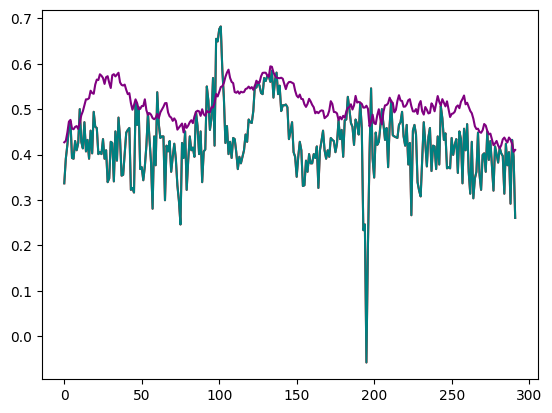

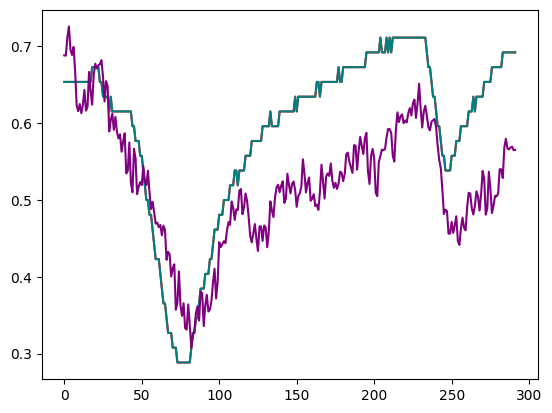

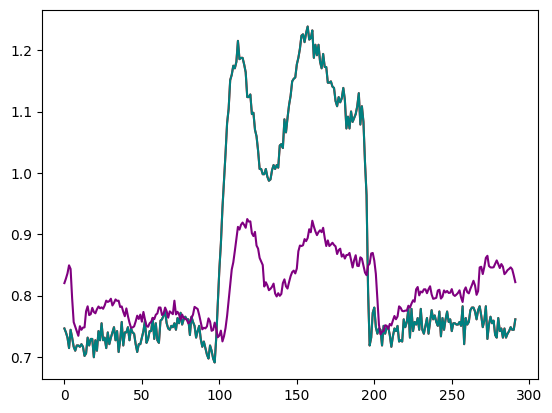

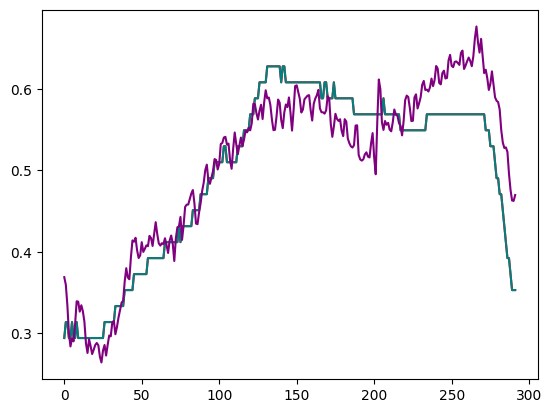

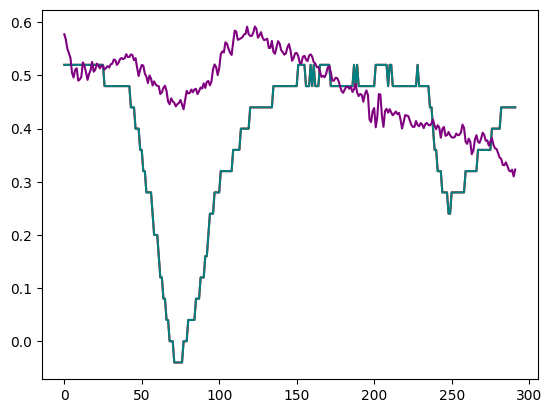

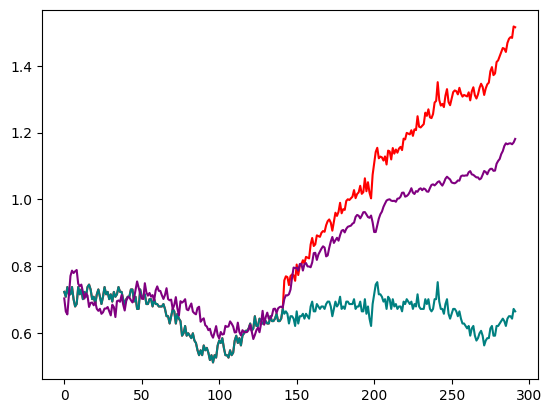

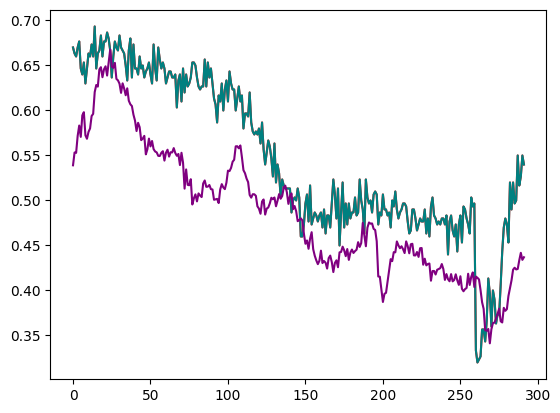

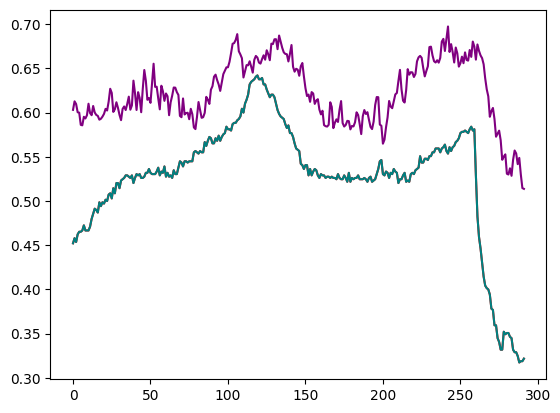

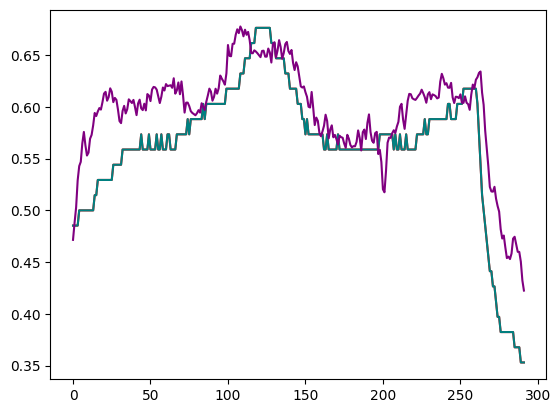

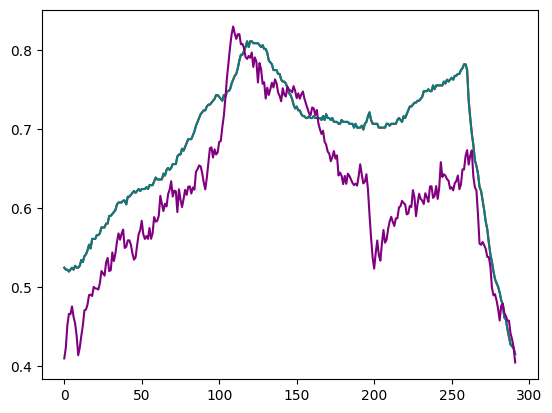

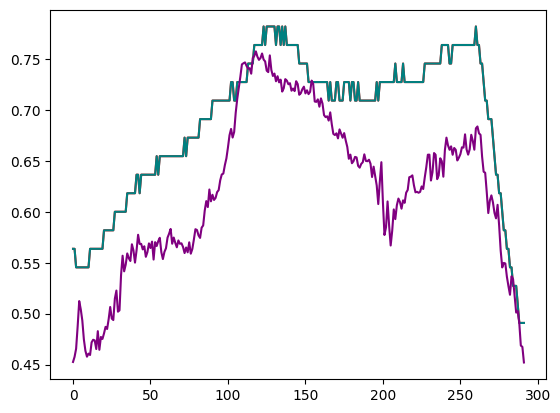

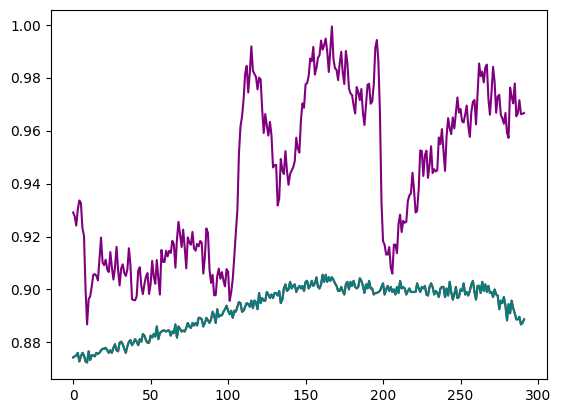

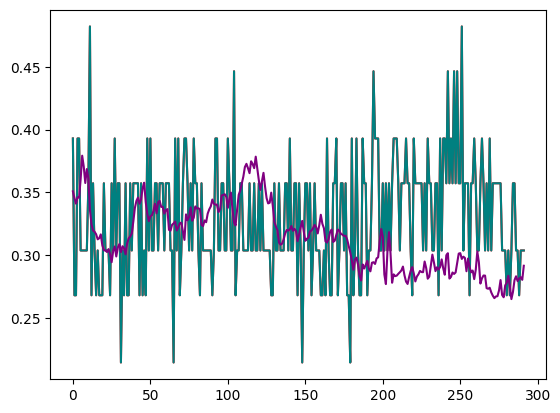

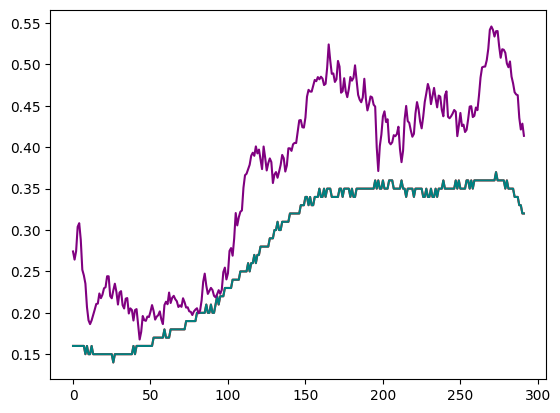

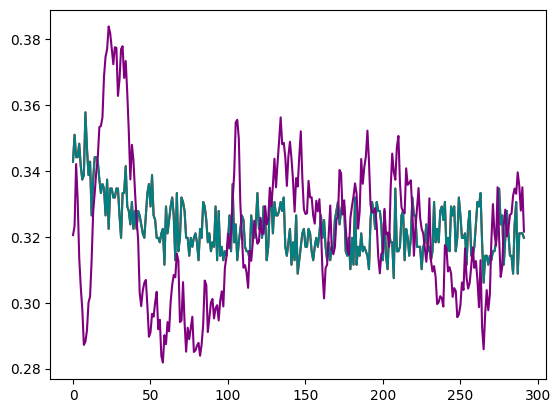

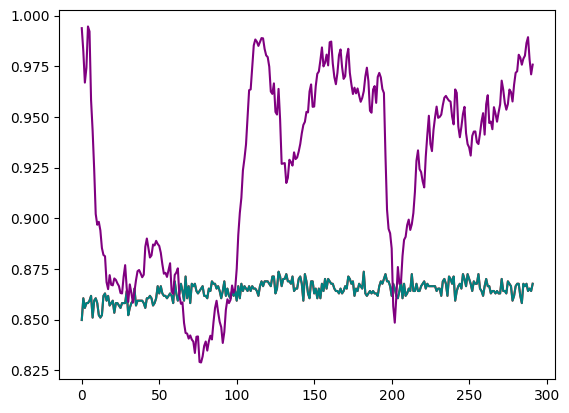

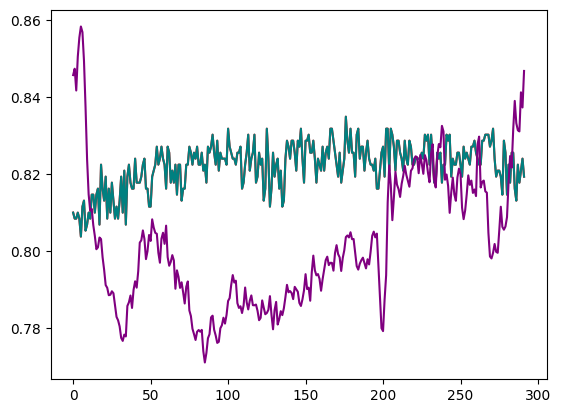

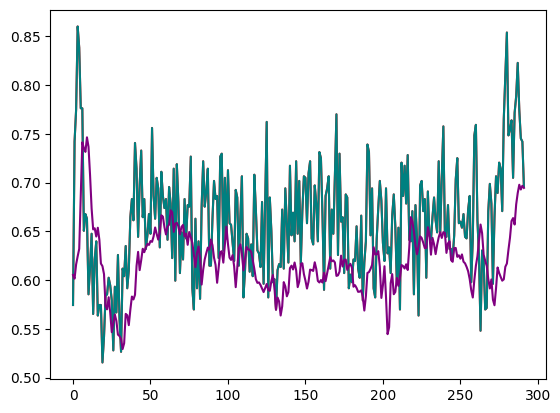

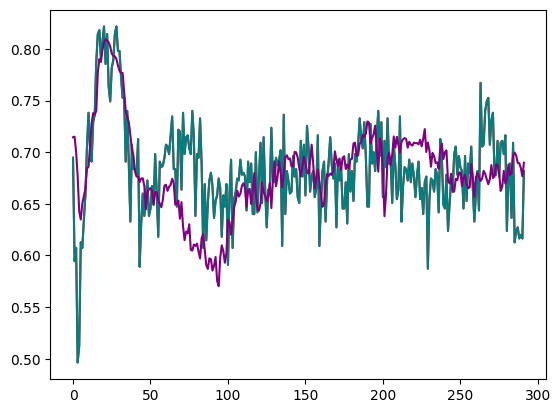

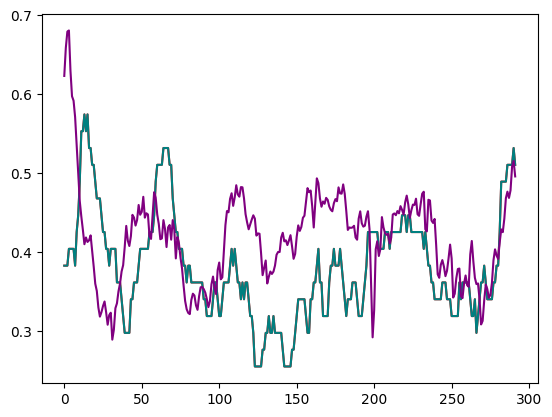

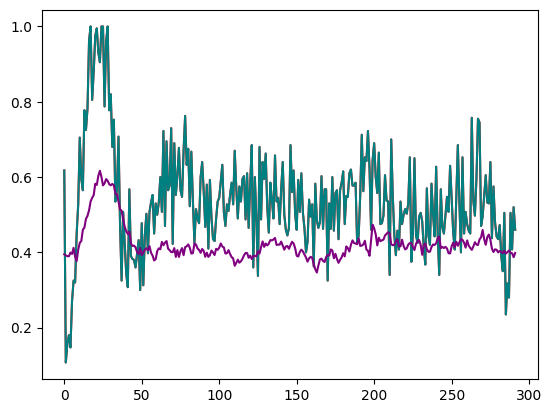

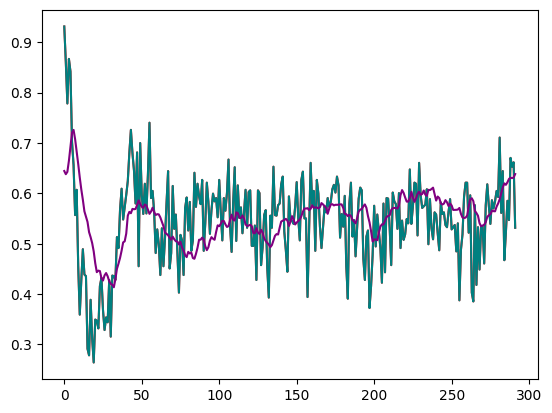

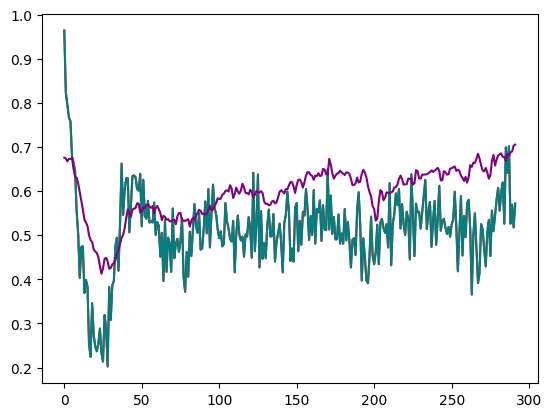

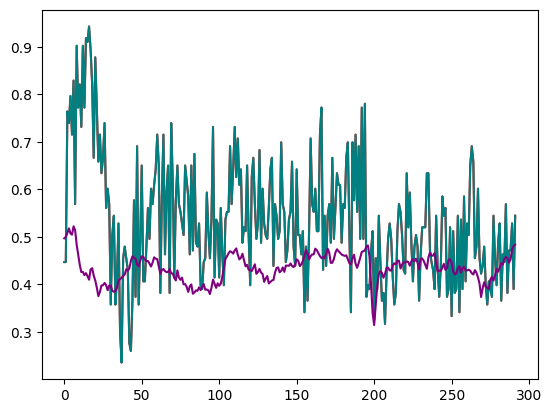

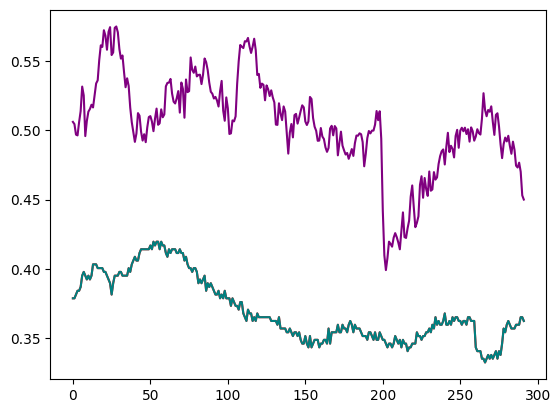

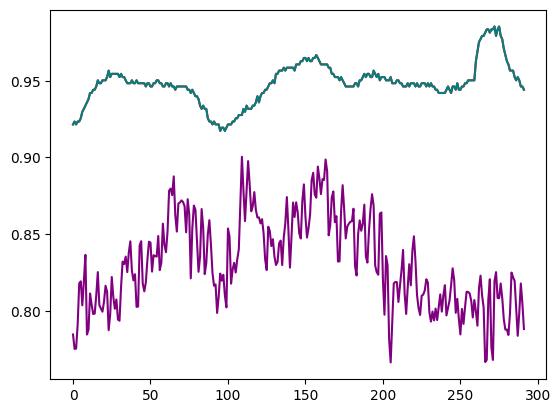

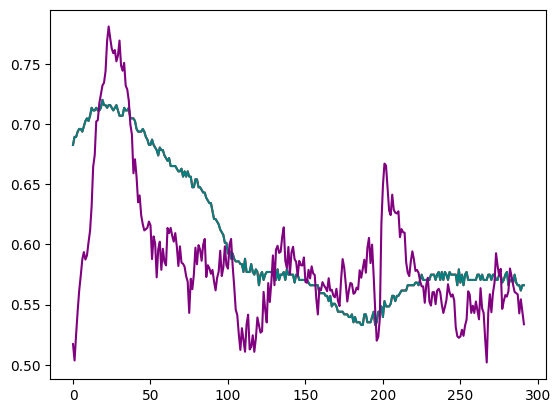

In [59]:
# With 1D Convolution and both GATs
import matplotlib.pyplot as plt

for i in range(window.shape[1]):
    plt.plot(targets_anom[:,i], label="target_anom", c="red")
    plt.plot(targets[:,i], label="target",c="teal")
    plt.plot(preds[:,i], label="pred", c="purple")
    plt.show()

## TODO:
1. ~~Save data (pred, infer, infer_anom, alpha_f, alpha_t)~~
2. ~~Look into time series plot (the pred, infer, infer_anom)~~
3. Look into dynamic graph visualization with weighted edges (pass in timestep)
    - Vary node size based on attention weight
    - Look into selecting attn head as drop down as well
4. Look into slider control to show highlighted square box on time series plot and select data for graph visualization